![Aeropython Logo](/files/imagenes/aeropython_logo.png)

# Optimización de aletas de refrigeración

Se quieren diseñar unas aletas de refrigeración destinadas al motor de un avión de caza multidisciplinar. Dicho avión tiene dos modos de funcionamiento nominal: un modo "espía-bombardero" y un modo "combate". Su altura de vuelo de crucero es de 14 km en ambos casos, donde __la temperatura ambiente es de $217 K$__.

Cuando el avión funciona en modo "espía-bombardero", vuela a M = 0.85. En dichas condiciones, el coeficiente de convección, __h, vale $350 W/K \cdot m^2$__. La superficie a enfriar se sitúa a temperaturas de alrededor de $400 K$.

Cuando el avión funciona en modo "combate", vuela a M = 1.5. En dichas condiciones, el coeficiente de convección, __h, vale $500 W/K \cdot m^2$__. La superficie a enfriar se sitúa a temperaturas de alrededor de $600 K$.

Las aletas presentarán simetría cilíndrica y podrán estar fabricadas en el material deseado del catálogo proporcionado a continuación. El precio no supone un problema, pero sí el peso, por lo que habrá que tenerlo en cuenta para la elección final del material. El radio de la superficie circular sobre la que se puede instalar cada aleta es de 10 milímetros y su longitud máxima es de 100 milímetros. 

Se quiere poder optimizar para tres parámetros de diseño: calor evacuado, resistencia aerodinámica de la aleta y peso. Por otro lado, se quieren diseñar aletas para tres versiones diferentes del avión, la versión "espía-bombardero" (con misiones 100 % de este tipo), la versión "caza" para misiones de patrulla y combate y una versión "multipropósito" a la que se quiere poder encomendar misiones de un tipo y otro indistintamente.

In [2]:
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style='ticks', palette='Set2')
%matplotlib inline
import numpy as np
from scipy.special import binom
import pandas as pd
from IPython.display import HTML
import random as random
import time
from scipy import integrate

##Materiales 

Para fabricar estas aletas, se dispone de un catálogo de materiales como el siguiente:

In [3]:
data = {
    #'Material' : ['Latón', 'Cobre', 'Zinc', 'Aluminio', 'Aluminio (al.)', 'Policarbonato', 'Plomo', 'Acero'],
    'Density (kg/m3)' : [8500, 8900, 7140, 2700, 2800, 1200, 11340, 7800],
    'Conductivity (W/mK)' : [85, 401, 116, 237, 160, 0.2, 35, 45]
}
catalogue = pd.DataFrame(data, columns=['Density (kg/m3)', 'Conductivity (W/mK)'], index = ['Latón', 'Cobre', 'Zinc', 'Aluminio', 'Aluminio (al.)', 'Policarbonato', 'Plomo', 'Acero'])
catalogue

,Density (kg/m3),Conductivity (W/mK)
Latón,8500,85.0
Cobre,8900,401.0
Zinc,7140,116.0
Aluminio,2700,237.0
Aluminio (al.),2800,160.0
Policarbonato,1200,0.2
Plomo,11340,35.0
Acero,7800,45.0


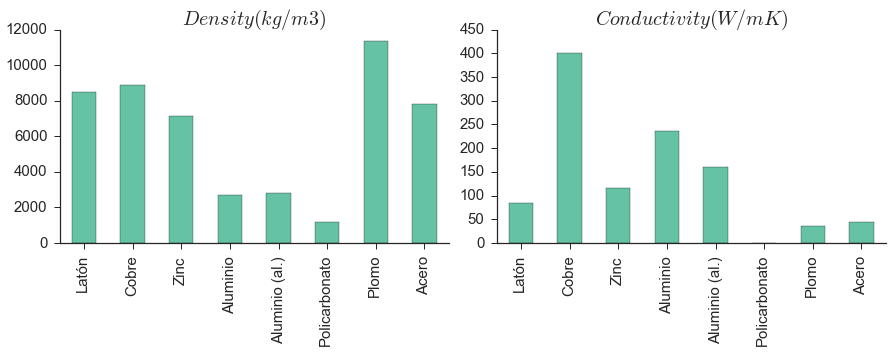

In [4]:
fig1 = plt.figure(figsize=(12.5, 5))

plt.subplot(121)
catalogue['Density (kg/m3)'].plot(kind='bar',  fontsize=15, grid = False)
plt.title('$Density (kg/m3)$', fontsize=20)
sns.despine()

plt.subplot(122)
catalogue['Conductivity (W/mK)'].plot(kind='bar',  fontsize=15, grid = False)
plt.title('$Conductivity (W/mK)$', fontsize=20)
sns.despine()

fig1.tight_layout()

Como sólo hay 8 materiales, 3 bits bastarán para codificarlos, pero vamos a ordenarlos de una manera más significativa, dividiendo densidad por conductividad.

In [5]:
catalogue['Material'] = ['Latón', 'Cobre', 'Zinc', 'Aluminio', 'Aluminio (al.)', 'Policarbonato', 'Plomo', 'Acero']
catalogue['Density/Conductivity'] = catalogue['Density (kg/m3)']/catalogue['Conductivity (W/mK)']
catalogue = catalogue.sort('Density/Conductivity', ascending=True)
#catalogue.reset_index(inplace=True)
#catalogue = catalogue.rename(columns={'index': 'Material'})
catalogue['Genes'] = ['000', '001', '010', '011', '100', '101', '110', '111']
catalogue = catalogue [['Material', 'Genes', 'Density (kg/m3)', 'Conductivity (W/mK)', 'Density/Conductivity']]
catalogue

,Material,Genes,Density (kg/m3),Conductivity (W/mK),Density/Conductivity
Aluminio,Aluminio,000,2700,237.0,11.392405
Aluminio (al.),Aluminio (al.),001,2800,160.0,17.500000
Cobre,Cobre,010,8900,401.0,22.194514
Zinc,Zinc,011,7140,116.0,61.551724
Latón,Latón,100,8500,85.0,100.000000
Acero,Acero,101,7800,45.0,173.333333
Plomo,Plomo,110,11340,35.0,324.000000
Policarbonato,Policarbonato,111,1200,0.2,6000.000000


In [6]:
#catalogue['Genes'][7]

In [7]:
#catalogue['Price (dollars/m3)']['Latón']

##Geometría

Geométricamente, se necesita una curva monótona descendiente. Para describirla, se generará una curva de Bézier de cuarto orden (esto es, usando cuatro puntos) que darán lugar a una curva de tercer grado. Para determinar dicha curva hay cinco grados de libertad:

 | $P_0$| $P_1$| $P_2$| $P_3$
:------:|:------:|:------:|:------:|:------:
$X$     | $0$      | $x_1$  | $x_2$  | $0.1$     
$Y$     | $0.01  $ | $y_1$  | $y_2$  | $y_3$
                     

Que deben respetar una serie de condiciones, unas impuestas por las especificaciones y otras para evitar generar curvas con puntos de inflexión. En la punta, se impone un ancho mínimo de 1 mm por motivos de fabricabilidad.

$$0 \leq x_1, x_2 \leq 0.1$$
$$ 0.0005 \leq y_3 \leq y_1, y_2 \leq 0.01$$

Una forma más significativa de determinar las coordenadas de los puntos $P_1$ y $P_2$ consiste en hacerlo en función de los ángulos $\alpha$ y $\beta$ que forman con la horizontal los segmentos que unen $P_{0}$ con $P_{1}$ y $P_{2}$ con $P_{3}$, respectivamente, así como la longitud de dichos segmentos. Los ángulos son los de las tangentes locales en los extremos y las distancias gobiernan cuánto tarda en separarse la curva de la tangente en los extremos. Los ángulos deben respetar que:

$$ 0 \leq \alpha, \beta \leq \frac{\pi}{2}$$

Y en el genoma se podrán caracterizar a partir de dos coeficientes tales que:

$$ 0 \leq c_{\alpha}, c_{\beta} \leq 1$$
$$$$
$$\alpha = c_{\alpha} \cdot \frac{\pi}{2}$$
$$$$
$$\beta = c_{\beta} \cdot \frac{\pi}{2}$$

Para determinar las longitudes de los segmentos, usarán en el genoma dos coeficientes $c_1$ y $c_2$ tales que:

$$ 0 \leq c_1, c_2 \leq 1$$

$$\frac{r_1}{c_1} = min \bigg ( \frac{0.01 - y_3}{\sin(\alpha)} , \frac{0.1}{\cos(\alpha)} \bigg)$$

$$\frac{r_2}{c_2} = min \bigg ( \frac{0.01 - y_3}{\sin(\beta)} , \frac{0.1}{\cos(\beta)} \bigg)$$

Y un tercer coeficiente tal que:

$$ 0 \leq c_3 \leq 1$$
$$y_3 = 0.0005 + c_3 \cdot (0.0095)$$

De tal forma que los coordenadas de los puntos intermedios valen:

$$x_1 = r_1 \cdot \cos(\alpha)$$
$$y_1 = 0.01- r_1 \cdot \sin(\alpha)$$
$$$$
$$x_2 = 0.1 - r_2 \cdot \cos(\beta)$$
$$y_2 = y_3 + r_2 \cdot \sin(\beta)$$

A partir de las coordenadas de estos puntos, ya se puede trazar la curva de Bézier. Por ejemplo, puede verse el perfil que se generará a partir de los puntos:

$$P_0[0, 0.01], P_1[0.05, 0.01], P_2[0.05, 0.001], P_3[0.1, 0.001]$$

In [9]:
def Bernstein(n, k):
    """Bernstein polynomial.
    Thanks, Juan Luis Cano!

    """
    coeff = binom(n, k)
 
    def _bpoly(x):
        return coeff * x ** k * (1 - x) ** (n - k)
 
    return _bpoly

def Bezier(points, num=200):
    """Build Bézier curve from points.
    Thanks, Juan Luis Cano!

    """
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for ii in range(N):
        curve += np.outer(Bernstein(N - 1, ii)(t), points[ii])
    return curve

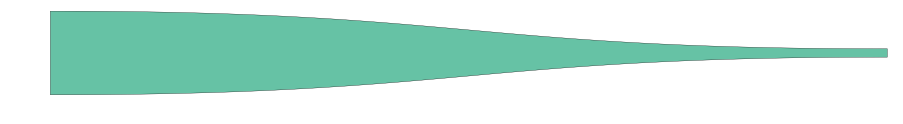

In [10]:
points = [[0, 0.01], [0.05, 0.01],[0.05, 0.001], [0.1, 0.001]]
curve = Bezier(points, 100)

example_plot_2D = plt.figure(figsize=(15,1.5))
plt.axis((0, 0.1, -0.01, 0.01))
plt.axis('off')
plt.fill_between(curve[:,0], curve[:,1], -curve[:,1])

Las áreas de cada sección y las áreas laterales entre secciones se calculan teniendo en cuenta que la aleta presenta simetría de revolución, por lo que las primeras son círculos y las segundas se aproximan como troncos de cono, según las expresiones:

$$A^i = \pi \cdot f(x^i)^2$$
$$$$
$$A_L^i = \pi \cdot (f(x^i) + f(x^{i+1})) \cdot \sqrt{(f(x^i) - f(x^{i+1}))^2 + (x^{i+1} - x^i)^2} $$

Análogamente, el volumen también se calcula como la suma de troncos de cono diferenciales:

$$V^i = \pi \cdot \frac{x^{i+1} - x^i}{3} \cdot (f(x^i)^2 + f(x^{i+1})^2 + f(x^i) \cdot f(x^{i+1} )) $$

Representando para la curva de ejemplo se ve que la discretización no es uniforme y que cada 'rebanada' de aleta tiene un espesor y volumen diferente:

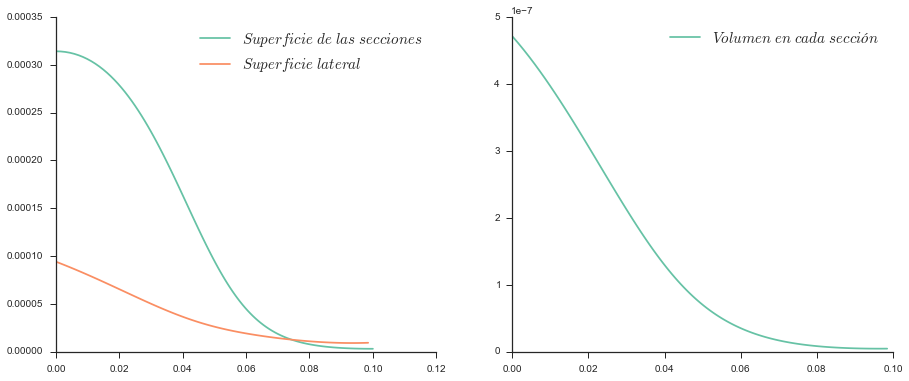

In [11]:
A = np.pi * curve[:,1] * curve[:,1]

A_lat = np.zeros(len(curve)-1)
volumes = np.zeros(len(curve)-1)

for ii in range(len(curve[:,0])-1):
    A_lat[ii] = np.pi * (curve[ii, 1] + curve[ii+1, 1]) * np.sqrt((curve[ii, 1] - curve[ii+1, 1])**2 + (curve[ii+1, 0] - curve[ii, 0])**2)
    volumes[ii] = (np.pi/3) * (curve[ii+1, 0] - curve[ii, 0]) * (curve[ii,1]**2 + curve[ii+1, 1]**2 + curve[ii,1]*curve[ii+1, 1])

fig_surfaces_volumes = plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(curve[0:(len(curve)),0], A, label = '$Superficie$ $de$ $las$ $secciones$')
plt.plot(curve[0:(len(curve)-1),0], A_lat, label = '$Superficie$ $lateral$')
plt.legend(fontsize=15)
sns.despine()

plt.subplot(122)
plt.plot(curve[0:(len(curve)-1),0], volumes, label = '$Volumen$ $en$ $cada$ $sección$')
plt.legend(fontsize=15)
sns.despine()

##Ecuación del calor

Desde el encastre, el calor se difunde por conducción, hacia la punta de la aleta y, a su vez, se pierde por convección a través de las paredes laterales. 

__La ecuación de conducción__ a través de una superficie de área $A$ tiene la forma:

$$\frac{dQ}{dt} = k \cdot A \cdot \frac{dT}{dx} $$

__La ecuación de convección__ a través de una superficie lateral $A_L$ sigue la expresión de la Ley de Enfriamiento de Newton para un cuerpo caliente en un ambiente frío, es decir:

$$\frac{dQ}{dt} = h \cdot A_L \cdot (T_{aleta} - T_{\infty})$$

El calor que cada sección de la aleta recibe por conducción, o bien lo transmite también por conducción a la sección siguiente o bien se pierde por convección en el ambiente. Para un estado estacionario y particularizando para cada sección de la aleta, se obtiene la siguiente __discretización de la ecuación del calor__, cuya resolución es directa escribiéndola en forma matricial:

$$k \cdot A^i \cdot \frac{T^i - T^{i-1}}{x^i - x^{i-1}} = k \cdot A^{i+1} \cdot \frac{T^{i+1} - T^i}{x^{i+1} - x^i} - h \cdot A^i_L \cdot (T^i - T_{\infty}) $$

En forma matricial se expresa como:

$$[M] \cdot {T} = {B}$$

donde: 

$$M^{i, i-1} = -\frac{k \cdot A^{i}}{x^i - x^{i-1}}$$

$$M^{i, i} = \frac{k \cdot A^{i}}{x^i - x^{i-1}} + \frac{k \cdot A^{i+1}}{x^{i+1} - x^{i}} + h \cdot A_L^i$$

$$M^{i, i+1} = -\frac{k \cdot A^{i+1}}{x^{i+1} - x^{i}}$$

$$B^i = h \cdot A_L^i \cdot T_{\infty}$$

Se toma como condiciones de contorno que la primera sección, la del encastre, se encuentra siempre a la temperatura del sistema y que la última no pierde calor por conducción, sino sólo convección a través de toda su superficie. Queda:

$$M^{1, 1} = 1$$
$$M^{1, 2} = 0$$

$$M^{N, N} = \frac{k \cdot A^{N}}{x^N - x^{N-1}} + h \cdot A^N$$
$$M^{N, N-1} = -\frac{k \cdot A^{N}}{x^N - x^{N-1}}$$

$$B^1 = T_{refrigeración}$$

$$B^N = h \cdot A^N \cdot T_{\infty}$$

Y el resto de los elementos son nulos.

La potencia calorífica evacuada en la primera sección, vendrá dada por la expresión:

$$\dot Q = k \cdot A^{1} \cdot \frac{T^{1} - T^0}{x^{1}} - h \cdot A^0_L \cdot (T^0 - T_{\infty}) $$

In [12]:
def power(curve, T_hot, T_inf, k, h, plot=False):
    
    x = curve[:,0]
    N = np.size(curve[:,0])

    A = np.pi * curve[:,1] * curve[:,1]
    A_lat = np.zeros(N-1)
    for ii in range(N-1):
            A_lat[ii] = np.pi * (curve[ii, 1] + curve[ii+1, 1]) * np.sqrt((curve[ii, 1] - curve[ii+1, 1])**2 + (curve[ii+1, 0] - curve[ii, 0])**2)

    T = np.zeros(N)
    M = np.zeros([N,N])
    B = np.zeros(N)

    M[0,0] = 1
    M[N-1, N-1] = (k*A[N-1]/(x[N-1]-x[N-2])) + h*(A[N-1])
    M[N-1, N-2] = -k*A[N-1]/(x[N-1]-x[N-2])
    B[0] = T_hot
    B[N-1] = h*(A[N-1])*T_inf

    for i in range(1,N-1):
        M[i, i] = (k*A[i]/(x[i]-x[i-1])) + (k*A[i+1]/(x[i+1]-x[i])) + h*A_lat[i]
        M[i, i-1] = -k*A[i]/(x[i]-x[i-1])
        M[i, i+1] = -k*A[i+1]/(x[i+1]-x[i])
        B[i] = h*A_lat[i]*T_inf
    
    T = np.dot(np.linalg.inv(M),B)
    Q = k * A[1]*(T[1]-T[0])/(x[1]-x[0]) - h * A_lat[0] * (T[0] - T_inf) 
    
    garbage = plt.figure(figsize=(30, 3))
    ax = garbage.add_subplot(111)
    plt.axis((0, 0.1, -0.01, 0.01))
    plt.axis('off')
    aleta = plt.fill_between(curve[:,0], curve[:,1], -curve[:,1], facecolor="#cccccc")
    plt.close()
    
    if plot==True:     
        xx, MM = np.meshgrid(curve[:,0], T)
        fig = plt.figure(figsize=(30, 3))
        ax = fig.add_subplot(111)
        plt.axis((0, 0.1, -0.01, 0.01))
        plt.axis('off')
        im = ax.imshow(MM.transpose(), extent=(0, 0.1, -0.01, 0.01), cmap=cm.RdYlBu_r)
        cb = fig.colorbar(im)
        cb.set_label("Temperature (K)")       
        
        
        patch = patches.PathPatch(aleta.get_paths()[0], fc='none', lw=2)
        ax.add_patch(patch)
        im.set_clip_path(patch)
    
    
        
    return Q

In [13]:
def weight (curve, material):
    
    N = np.size(curve[:,0])
    volumes = np.zeros(N-1)

    for i in range(N-1):
        volumes[i] = (np.pi/3) * (curve[i+1, 0] - curve[i, 0]) * (curve[i,1]**2 + curve[i+1, 1]**2 + curve[i,1]*curve[i+1, 1])
    
    weight = np.sum(volumes) * catalogue['Density (kg/m3)'][material]
    
    return weight

Calculando el perfil de temperaturas para la curva de ejemplo, en el caso en que estuviera fabricada en plomo, se obtiene:

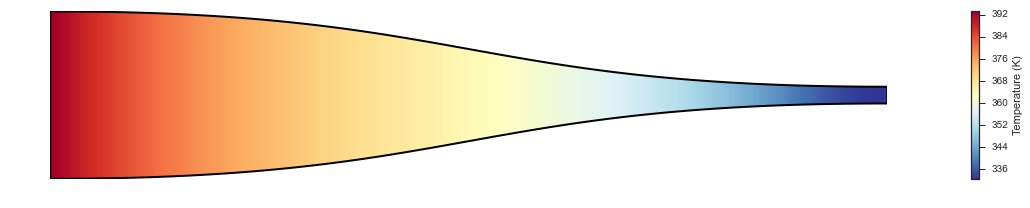

In [14]:
Q = power(curve, 393.15, 293.15, 401, 400, plot=True)

In [15]:
#weight (curve, 'Latón')

##Resistencia aerodinámica

En los cuerpos romos, como estas aletas de sección circular, la resistencia asociada a la presión domina a la resistencia producida por la fricción del aire. Esto hace que la resistencia se pueda considerar como proporcional a la sección transversal de la aleta.

![Drag](/files/imagenes/drag.png)

## Función de mérito

La función de mérito se va a definir en relación a los mejores y peores desempeños posibles, con la definición geométrica establecida y los materiales disponibles. La aleta más grande posible (llamada a continuación "aleta máxima") y la aleta más pequeña posible ("aleta mímima") están definidas como sigue:

$Aleta$ $máxima:$ $$P_0[0, 0.01], P_1[0.05, 0.01], P_2[0.05, 0.01], P_3[0.1, 0.01]$$

$Aleta$ $mínima:$ $$P_0[0, 0.01], P_1[0, 0.0005], P_2[0, 0.0005], P_3[0.1, 0.0005]$$

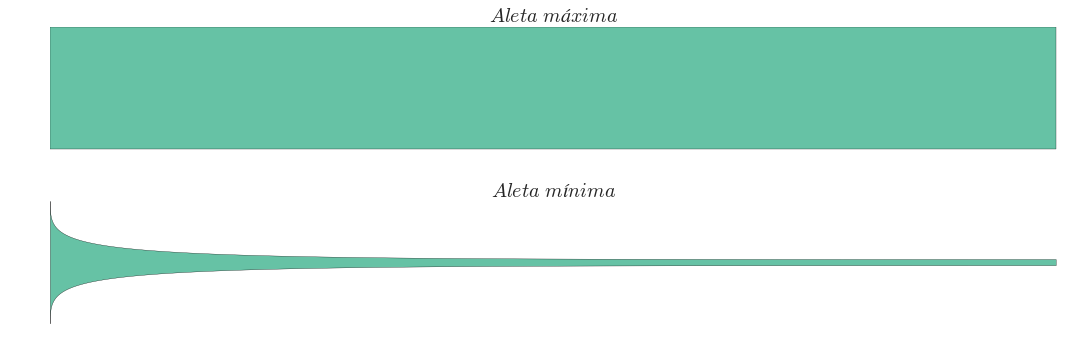

In [16]:
points_max = [[0, 0.01], [0.05, 0.01],[0.05, 0.01], [0.1,0.01]]
curve_max = Bezier(points_max, 100)
points_min = [[0, 0.01], [0, 0.0005],[0, 0.0005], [0.1,0.0005]]
curve_min = Bezier(points_min, 100)

fig_max_min = plt.figure(figsize=(15,5))

plt.subplot(211)
plt.title('$Aleta$ $máxima$', fontsize=20)
plt.axis((0, 0.1, -0.01, 0.01))
plt.axis('off')
plt.fill_between(curve_max[:,0], curve_max[:,1], -curve_max[:,1])

plt.subplot(212)
plt.title('$Aleta$ $mínima$', fontsize=20)
plt.axis((0, 0.1, -0.01, 0.01))
plt.axis('off')
plt.fill_between(curve_min[:,0], curve_min[:,1], -curve_min[:,1])

fig_max_min.tight_layout()

Los desempeños máximos y mínimos están recogidos en la tabla siguiente:

In [17]:
Q_1_max = power(curve_max, 400, 217, catalogue['Conductivity (W/mK)']['Cobre'], 350)
Q_1_min = power(curve_min, 400, 217, catalogue['Conductivity (W/mK)']['Policarbonato'], 350)
Q_2_max = power(curve_max, 600, 217, catalogue['Conductivity (W/mK)']['Cobre'], 500)
Q_2_min = power(curve_min, 600, 217, catalogue['Conductivity (W/mK)']['Policarbonato'], 500)
weight_max = weight (curve_max, 'Cobre')
weight_min = weight (curve_min, 'Policarbonato')
A_T_max = 2 * integrate.simps(curve_max[:, 1], curve_max[:,0])
A_T_min = 2 * integrate.simps(curve_min[:, 1], curve_min[:,0])


performances_dict = {
    '$\dot Q^{espía}_{max} (W)$' : ['Máxima', 'Cobre', Q_1_max],
    '$\dot Q^{espía}_{min} (W)$' : ['Mínima', 'Policarbonato', Q_1_min],
    '$\dot Q^{combate}_{max} (W)$' : ['Máxima', 'Cobre', Q_2_max],
    '$\dot Q^{combate}_{min} (W)$' : ['Mínima', 'Policarbonato', Q_2_min],
    '$P_{max} (kg)$' : ['Máxima', 'Cobre', weight_max],
    '$P_{min} (kg)$' : ['Mínima', 'Policarbonato', weight_min],
    '$A^{transv}_{max} (m^2)$' : ['Máxima', '-', A_T_max],
    '$A^{transv}_{min} (m^2)$' : ['Mínima', '-', A_T_min]
}

performances = pd.DataFrame(performances_dict, 
                            columns = ['$\dot Q^{espía}_{max} (W)$', 
                                       '$\dot Q^{espía}_{min} (W)$', 
                                       '$\dot Q^{combate}_{max} (W)$', 
                                       '$\dot Q^{combate}_{min} (W)$', 
                                       '$P_{max} (kg)$', 
                                       '$P_{min} (kg)$',
                                       '$A^{transv}_{max} (m^2)$',
                                       '$A^{transv}_{min} (m^2)$'
                                      ], 
                            index = ['Aleta', 'Material', 'Valor'])
performances

,$\dot Q^{espía}_{max} (W)$,$\dot Q^{espía}_{min} (W)$,$\dot Q^{combate}_{max} (W)$,$\dot Q^{combate}_{min} (W)$,$P_{max} (kg)$,$P_{min} (kg)$,$A^{transv}_{max} (m^2)$,$A^{transv}_{min} (m^2)$
Aleta,Máxima,Mínima,Máxima,Mínima,Máxima,Mínima,Máxima,Mínima
Material,Cobre,Policarbonato,Cobre,Policarbonato,Cobre,Policarbonato,-,-
Valor,-270.5784,-14.54057,-714.4895,-41.22442,0.2796017,0.0006787982,0.002,0.0001949995


Con estos valores ya se puede definir una función de mérito a partir de unos pesos $\omega_{espía}$ y $\omega_{combate}$ por un lado y $\omega_{convección}$, $\omega_{peso}$ y $\omega_{resistencia}$ por otro:

$$ \Phi = \omega_{espía} *  \bigg [\omega_{convección} \cdot \frac{\dot Q^{espía} - \dot Q^{espía}_{min}}{\dot Q^{espía}_{max} - \dot Q^{espía}_{min}} + \omega_{peso} \cdot \frac{P_{max} - P}{P_{max} - P_{min}} + \omega_{resistencia} \cdot \frac{A_{max} - A}{A_{max} - A_{min}}\bigg] + \\ \omega_{combate} *  \bigg [\omega_{convección} \cdot \frac{\dot Q^{combate} - \dot Q^{combate}_{min}}{\dot Q^{combate}_{max} - \dot Q^{combate}_{min}} + \omega_{peso} \cdot \frac{P_{max} - P}{P_{max} - P_{min}} + \omega_{resistencia} \cdot \frac{A_{max} - A}{A_{max} - A_{min}}\bigg]$$

In [18]:
def phi(curve, material, omega_spy = 1, omega_combat = 1, omega_C=1, omega_P=0, omega_D=0):
    
    sum_omega = omega_spy + omega_combat
    omega_spy, omega_combat = omega_spy/sum_omega, omega_combat/sum_omega
    
    sum_omega = omega_C + omega_P + omega_D
    omega_C, omega_P, omega_D = omega_C/sum_omega, omega_P/sum_omega, omega_D/sum_omega
    
    Q_spy = power(curve, 400, 217, catalogue['Conductivity (W/mK)'][material], 350)
    Q_combat = power(curve, 600, 217, catalogue['Conductivity (W/mK)'][material], 500)
    P = weight (curve, material)
    A_T = 2 * integrate.simps(curve[:, 1], curve[:,0])
    
    phi_C_spy = omega_C * (Q_spy - Q_1_min) / (Q_1_max - Q_1_min)
    phi_C_combat = omega_C * (Q_combat - Q_2_min) / (Q_2_max - Q_2_min)
    phi_weight = omega_P * (weight_max - P) / (weight_max - weight_min)
    phi_D = omega_D * (A_T_max-A_T)/(A_T_max-A_T_min)
    
    phi = omega_spy* (phi_C_spy + phi_weight + phi_D) + omega_combat* (phi_C_combat + phi_weight + phi_D)
    
    return phi, Q_spy, Q_combat, P, A_T

In [19]:
#phi(curve, "Aluminio")

##Individuos y genoma

El genoma consistirá en una serie de bits diferente para cada individuo de la población. Se han tomado 3 bits para determinar el material y se decide tomar __cinco bits para determinar cada coeficiente__, es decir, sólo podrán tomar ocho valores distintos, equiespaciados, entre 0 y 1. El genoma estará formado por 28 bits, repartidos en 5 bloques de 5 y un bloque de 3, a partir de los cuales se determinarán los valores de los coeficientes y el material elegido:

| | | | | |
:------:|:------:|:------:|:------:|:------:|:------:
$c_{\beta}$| $c_{\alpha}$| $c_3$| $c_2$| $c_1$| $Material$
| | | | | 

In [20]:
class Individual (object):
    
    def __init__(self, genome):
        
        self.genome = genome
        
        gen_beta, gen_alpha, gen_3, gen_2, gen_1, gen_mat = '', '', '', '', '', ''
        self.P1, self.P2, self.P3 = [], [], []
        
        for i in range(5):
            gen_beta += str(self.genome[i])
            gen_alpha += str(self.genome[5+i])
            gen_3 += str(self.genome[10+i])
            gen_2 += str(self.genome[15+i])
            gen_1 += str(self.genome[20+i])
        
        for i in range(3):
            gen_mat += str(self.genome[25+i])
        
        self.C_beta = int (gen_beta, 2)/31.0
        self.C_alpha = int (gen_alpha, 2)/31.0
        self.C_3 = int (gen_3, 2)/31.0
        self.C_2 = int (gen_2, 2)/31.0
        self.C_1 = int (gen_1, 2)/31.0
        self.material = int (gen_mat, 2)
        
        self.beta = self.C_beta * (np.pi/2)
        self.alpha = self.C_alpha * (np.pi/2)
        
        x3 = 0.1
        y3 = 0.0005 + self.C_3 * 0.0095
        
        r2_max = min ((0.01-y3)/np.sin(self.beta), 0.1/np.cos(self.beta))
        r1_max = min ((0.01-y3)/np.sin(self.alpha), 0.1/np.cos(self.alpha))
        
        r1 = self.C_1 * r1_max
        r2 = self.C_2 * r2_max
            
        x1 = r1 * np.cos(self.alpha)
        y1 = 0.01 - r1*np.sin(self.alpha)
        x2 = 0.1 - r2*np.cos(self.beta)
        y2 = y3 + r2*np.sin(self.beta)
        
        self.P0 = [0, 0.01]
        self.P1.append(x1)
        self.P1.append(y1)
        self.P2.append(x2)
        self.P2.append(y2)
        self.P3.append(x3)
        self.P3.append(y3)
        
        self.points = [self.P0, self.P1, self.P2, self.P3]
        
        self.curve = Bezier(self.points, 100)
        self.phi, self.Q_spy, self.Q_combat, self.weight, self.A_T = phi(self.curve, self.material)
        
    def plot(self):
        fig = plt.figure(figsize=(15,1.5))
        plt.axis((0, 0.1, -0.01, 0.01))
        plt.axis('off')
        plt.fill_between(self.curve[:,0], self.curve[:,1], -self.curve[:,1])

Por ejemplo, se puede obtener una aleta a partir del genoma:

$$[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]$$

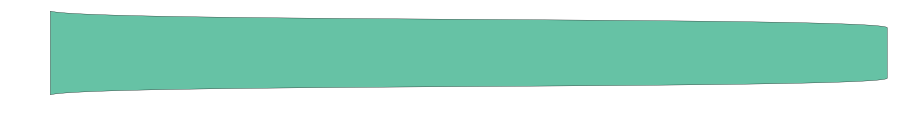

In [21]:
individuo = Individual ([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1])
individuo.plot()

##Funciones genéticas

Para el éxito de este algoritmo serán necesaria la creación de los operadores que, actuando sobre la población de soluciones ejercerán el papel de la selección natural, mejorando el genoma del conjunto de la población generación tras generación.

Se crea, primero, una función "__inicio(población)__" que tiene por objeto generar una primera muestra poblacional aleatoria a partir de la cual comenzar a aplicar el algoritmo.

In [22]:
randBinList = lambda n: [random.randint(0,1) for b in range(1,n+1)]

def boot(population):
    society = []
    for i in range (population):
        new_individual = Individual(randBinList(28))
        society.append(new_individual)
    return society

La función "__inmigración(sociedad, tasa de migración)__" tiene una función similar, añade a la sociedad objetivo una serie de individuos aleatorios cuyo número depende de una tasa de migración dada. Esta función tiene por vocación representar la variabilidad genética que se introduce en una población con la llegada de extranjeros.

In [23]:
def inmigration (society, migration_rate):
    for i in range (int(np.ceil(len(society)*migration_rate))):
        new_individual = Individual(randBinList(28))
        society.append(new_individual)

La función "__cruce (sociedad, tasa de reproducción, tasa de mutación)__" es la encargada de la reproducción. En primer lugar, toma la sociedad objetivo y selecciona parejas de individuos aleatoriamente. La probabilidad de cada individuo depende de la calidad de su genoma, de tal manera que el individuo con el mejor genoma (es decir, la función de mérito más elevada) tiene N veces más probabilidades de reproducirse que el individuo con el peor genoma, donde N es el tamaño de la población. A continuación, divide los genomas de las parejas seleccionadas por dos puntos aleatorios y los mezcla para generar un nuevo genoma. El nuevo genoma está sujeto a una posible mutación, esto es, cada uno de los genes (bits) tiene una probabilidad de cambiar dada por la tasa de mutación. Finalmente, la función incorpora al nuevo individuo a la sociedad objetivo.

In [24]:
def weighted_choice_sub(weights):
    rnd = random.random() * sum(weights)
    for i, w in enumerate(weights):
        rnd -= w
        if rnd < 0:
            return i

def crossover (society, reproduction_rate, mutation_rate):
    
    phi_list = [individual.phi for individual in society]
    probability = [i for i in reversed(range(1,len(society)+1))]
    mutation = [1-mutation_rate, mutation_rate]    
    
    society = [x for (y,x) in sorted(zip(phi_list,society), key=lambda x: x[0], reverse=True)] #se ordenan los individuos de más apto a menos apto
    
    for i in range (int(len(society)*reproduction_rate)):
        father, mother = society[weighted_choice_sub(probability)], society[weighted_choice_sub(probability)]
        a, b = random.randrange(len(father.genome)), random.randrange(len(mother.genome))
        
        child_genome = father.genome[0:min(a,b)]+mother.genome[min(a,b):max(a,b)]+father.genome[max(a,b):]
        n = [weighted_choice_sub(mutation) for i in range(len(child_genome))]
        n, child_genome = np.array(n), np.array(child_genome)
        mutant_child_genome = abs(n-child_genome)
        
        society.append(Individual(mutant_child_genome.tolist()))
        
    return (society)

Por último, la función "__torneo(sociedad, población futura)__" elige aleatoriamente parejas de individuos de la sociedad objetivo y los enfrenta hasta que se ha alcanzado el nivel de población deseado. El individuo menos apto (aquel con la función de mérito más baja) "muere" y su abandona la sociedad.

In [25]:
def tournament(society, future_population):
    while (len(society)>future_population):
        index1, index2 = random.randrange(0,len(society)), random.randrange(0,len(society))
        if society[index1].phi < society[index2].phi:
            society.pop(index1)
        else:
            society.pop(index2)

In [26]:
#list1 = ['b', 'a', 'c', 'e', 'd']
#list2 = [1,3,1,2,3]
#list3 = [[list2[i], list1[i]] for i in range(len(list1))]
#list3.sort(key=lambda x: x[0], reverse=True)
#list1= [list3[i][1] for i in range (len(list3))]
#list1

##Algoritmo genético

En las poblaciones reales, el número de individuos no permanece constante a lo largo del tiempo, sino que sufre grandes oscilaciones. En épocas de bonanza y abundancia de recursos, los individuos se reproducen y se produce una inmigracion neta, con lo que la población aumenta enormemente. Por el contrario, en época de escasez los individuos deben competir por los recursos, por lo que la mortalidad y la emigración reducen el tamaño de la población. El siguiente algoritmo pretende reproducir esto. 

En un ciclo, se produce un efecto de inmigración y reproducción que hacen aumentar enormemente la población y la diversidad genética. Para favorecer la selección, los mejores individuos tienen más probabilidades de reproducirse. En el momento de la reproducción, también se introduce una tasa de mutación, que debe servir a aumentar la variabilidad genética y a ayudar a la solución a salir de máximos locales. Tras la reproducción, los individuos originales no son eliminados, sino que siguen conviviendo con los nuevos individuos, como ocurre en la mayoría de las poblaciones naturales. 

A las fases de inmigración y reproducción, sigue una fase de torneo, en la que parejas de individuos aleatorias son comparadas para eliminar a la solución menos apta. En esta segunda fase hay que tener cuidado de no reducir demasiado el tamaño de la población, lo que exacerbaría los efectos de la deriva genética.

In [27]:
omega_espia = 0
omega_combate = 1
omega_conveccion = 2
omega_peso = 2
omega_resistencia = 1
N_0 = 50
number_of_generations = 30
migration_rate = 0.1
reproduction_rate = 1
mutation_rate = 2/28

In [28]:
def phi(curve, material, omega_spy = omega_espia, omega_combat = omega_combate, omega_C=omega_conveccion, omega_P=omega_peso, omega_D=omega_resistencia):
    
    sum_omega = omega_spy + omega_combat
    omega_spy, omega_combat = omega_spy/sum_omega, omega_combat/sum_omega
    
    sum_omega = omega_C + omega_P + omega_D
    omega_C, omega_P, omega_D = omega_C/sum_omega, omega_P/sum_omega, omega_D/sum_omega
    
    Q_spy = power(curve, 400, 217, catalogue['Conductivity (W/mK)'][material], 350)
    Q_combat = power(curve, 600, 217, catalogue['Conductivity (W/mK)'][material], 500)
    P = weight (curve, material)
    A_T = 2 * integrate.simps(curve[:, 1], curve[:,0])
    
    phi_C_spy = omega_C * (Q_spy - Q_1_min) / (Q_1_max - Q_1_min)
    phi_C_combat = omega_C * (Q_combat - Q_2_min) / (Q_2_max - Q_2_min)
    phi_weight = omega_P * (weight_max - P) / (weight_max - weight_min)
    phi_D = omega_D * (A_T_max-A_T)/(A_T_max-A_T_min)
    
    phi = omega_spy* (phi_C_spy + phi_weight + phi_D) + omega_combat* (phi_C_combat + phi_weight + phi_D)
    
    return phi, Q_spy, Q_combat, P, A_T

In [29]:
#genes_adan = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0]
#genes_eva =  [0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0]
#adan = Individual(genes_adan)
#eva = Individual(genes_eva)

In [ ]:
start = time.time()

society = 25*[adan, eva]
print('Booting')
print('')
max_phi, min_phi, mean_phi, std_phi = [], [], [], []

generation = 0
print('*Generation: ', generation)
print(len(society), ' individuals')
phi_list = [individual.phi for individual in society]
max_phi.append(max(phi_list))
min_phi.append(min(phi_list))
mean_phi.append(np.mean(phi_list))
std_phi.append(np.std(phi_list))


for i in range(number_of_generations):
        
    inmigration(society, migration_rate)
    print('Inmigration')
    print(len(society), ' individuals')
    society = crossover(society, reproduction_rate, mutation_rate)
    print('Crossover')
    print(len(society), ' individuals')
    tournament(society, N_0)
    print('Tournament')
    print('')
    
    generation +=1
    print('*Generation: ', generation)
    print(len(society), ' individuals')
    phi_list = [individual.phi for individual in society]
    max_phi.append(max(phi_list))
    min_phi.append(min(phi_list))
    mean_phi.append(np.mean(phi_list))
    std_phi.append(np.std(phi_list))    
    
end = time.time()

In [43]:
#winner = society[phi_list.index(max(phi_list))]
#lapse = end - start

In [42]:
#heat = power(winner.curve, 400, 217, catalogue['Conductivity (W/mK)'][winner.material], 500, True)
#plt.title('$\omega_{espía}$ = '+str(omega_espia)+', $\omega_{combate}$ = '+str(omega_combate)+', $\omega_{Convección}$ = '+str(omega_conveccion)+', $\omega_{Peso}$ = '+str(omega_peso)+', $\omega_{Resistencia}$ = '+str(omega_resistencia)+'\n $\Phi$ ='+str(round(max(phi_list),2)), fontsize = 25)
#plt.text(0, -0.016, catalogue['Material'][winner.material]+': '+str(round(winner.weight,1))+' kg \n'+'Convección en modo espía: '+str(round(heat,1))+' $W$', fontsize = 20) 
#plt.text(0.044, -0.016, str(winner.genome), fontsize = 20)
#plt.savefig(str(omega_espia)+'_'+str(omega_combate)+'_'+str(omega_conveccion)+'_'+str(omega_peso)+'_'+str(omega_resistencia)+'_espia.png', dpi=300, bbox_inches='tight')

In [41]:
#heat = power(winner.curve, 600, 217, catalogue['Conductivity (W/mK)'][winner.material], 500, True)
#plt.title('$\omega_{espía}$ = '+str(omega_espia)+', $\omega_{combate}$ = '+str(omega_combate)+', $\omega_{Convección}$ = '+str(omega_conveccion)+', $\omega_{Peso}$ = '+str(omega_peso)+', $\omega_{Resistencia}$ = '+str(omega_resistencia)+'\n $\Phi$ ='+str(round(max(phi_list),2)), fontsize = 25)
#plt.text(0, -0.016, catalogue['Material'][winner.material]+': '+str(round(winner.weight,1))+' kg \n'+'Convección en modo combate: '+str(round(heat,1))+' $W$', fontsize = 20) 
#plt.text(0.044, -0.016, str(winner.genome), fontsize = 20)
#plt.savefig(str(omega_espia)+'_'+str(omega_combate)+'_'+str(omega_conveccion)+'_'+str(omega_peso)+'_'+str(omega_resistencia)+'_combate.png', dpi=300, bbox_inches='tight')

In [40]:

#fig = plt.figure(figsize=(15,5))
#plt.plot(max_phi, label='$\Phi_{max}$')
#plt.plot(min_phi, label='$\Phi_{min}$')
#plt.plot(mean_phi, label='$\overline{\Phi}$')
#plt.plot(std_phi, label='$\sigma_{\Phi}$')
#plt.title('$\omega_{espía}$ = '+str(omega_espia)+', $\omega_{combate}$ = '+str(omega_combate)+', $\omega_{Convección}$ = '+str(omega_conveccion)+', $\omega_{Peso}$ = '+str(omega_peso)+', $\omega_{Resistencia}$ = '+str(omega_resistencia)+'\n $\Phi$ ='+str(round(max(phi_list),2)), fontsize = 25)
#plt.xlabel('Generation', fontsize = 15)
#plt.legend(loc=4, fontsize=20)
#plt.text(5, 0.65, str(round(lapse,1))+' s', fontsize = 20)
#sns.despine()
#plt.savefig(str(omega_espia)+'_'+str(omega_combate)+'_'+str(omega_conveccion)+'_'+str(omega_peso)+'_'+str(omega_resistencia)+'_evolucion.png', dpi=300, bbox_inches='tight')


#Soluciones

A continuación se muestran los resultados de la evolución de una población aleatoria de 50 individuos a lo largo de 50 generaciones, con una tasa de reproducción del 100%. La tasa de inmigración es del 10% y la de mutación, de 1/28. Estos valores se han elegido bajos para obtener una evolución progresiva, no tan brusca como en optimizaciones anteriores.

##Avión espía-bombardero

En este caso, se quiere minimizar la resistencia, para aumentar la autonomía del avión.

![](/files/imagenes/1_0_2_1_2_evolucion.png)

![](/files/imagenes/1_0_2_1_2_espia.png)

##Avión de combate

En este caso, se quiere reducir el pero, para reducir la carga estructural y aumentar la relación Empuje/Peso.

![](/files/imagenes/0_1_2_2_1_evolucion.png)

![](/files/imagenes/0_1_2_2_1_combate_a.png)

Curiosamente, en otra optimización con sólo 30 individuos por población a lo largo de 30 generaciones, se obtuvo la optimización siguiente, que pese a tener una geometría totalmente distinta tiene una función de mérito del mismo orden:

![](/files/imagenes/0_1_2_2_1_combate_b.png)

Se ha decidido llevar a cabo un nuevo proceso de optimización, donde estos dos individuos (cuales Adán y Eva) son utilizados como población inicial, a fin de descubrir cuál de las dos geometrías es superior o si hay una geometría intermedia que sea más óptima. Al cabo de 60 generaciones, la primera de las soluciones seguía siendo la mejor de las obtenidas.

##Avión multipropósito

En este caso se quieren pesos equilibrados.

![](/files/imagenes/1_1_2_1_1_evolucion.png)

![](/files/imagenes/1_1_2_1_1_espia.png)

![](/files/imagenes/1_1_2_1_1_combate.png)

Carlos Dorado, Aeropython, 20 de abril de 2015